In [2]:
!pip install -q transformers datasets evaluate arabert gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.7 MB/s eta 0:00:00

In [3]:
import torch
from transformers import ElectraTokenizerFast, ElectraForQuestionAnswering, TrainingArguments, Trainer
from datasets import load_dataset
from arabert.preprocess import ArabertPreprocessor
import evaluate


In [4]:
dataset = load_dataset("tydiqa", "primary_task")

def is_arabic(example):
    return example["language"] == "arabic"

train_ar = dataset["train"].filter(is_arabic)
val_ar = dataset["validation"].filter(is_arabic)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

train-00000-of-00012.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00001-of-00012.parquet:   0%|          | 0.00/225M [00:00<?, ?B/s]

train-00002-of-00012.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

train-00003-of-00012.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00004-of-00012.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00005-of-00012.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

train-00006-of-00012.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

train-00007-of-00012.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00008-of-00012.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

train-00009-of-00012.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

train-00010-of-00012.parquet:   0%|          | 0.00/225M [00:00<?, ?B/s]

train-00011-of-00012.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/166916 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18670 [00:00<?, ? examples/s]

Filter:   0%|          | 0/166916 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18670 [00:00<?, ? examples/s]

In [5]:
from arabert.preprocess import ArabertPreprocessor
arabert_prep = ArabertPreprocessor("ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA")

def preprocess_text(example):

    raw_context = example["document_plaintext"]
    example["context"] = arabert_prep.preprocess(raw_context)


    raw_question = example["question_text"]
    example["question"] = arabert_prep.preprocess(raw_question)


    cand_idxs = example["annotations"]["passage_answer_candidate_index"]
    if cand_idxs:
        idx = cand_idxs[0]
        start_byte = example["passage_answer_candidates"]["plaintext_start_byte"][idx]
        end_byte   = example["passage_answer_candidates"]["plaintext_end_byte"][idx]
        raw_answer = raw_context[start_byte:end_byte]
        example["answer_text"]  = arabert_prep.preprocess(raw_answer)
        example["answer_start"] = example["context"].find(example["answer_text"])

        if example["answer_start"] < 0:
            example["answer_start"] = 0
    else:
        example["answer_text"]  = ""
        example["answer_start"] = 0

    return example


train_ar = train_ar.map(preprocess_text)
val_ar   = val_ar.map(preprocess_text)


Map:   0%|          | 0/23092 [00:00<?, ? examples/s]

Map:   0%|          | 0/1380 [00:00<?, ? examples/s]

In [6]:
tokenizer = ElectraTokenizerFast.from_pretrained("ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA")

def tokenize_function(example):

    tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )


    sequence_ids_list = []
    for i in range(len(tokenized_example["input_ids"])):

        seq_ids = tokenized_example.encodings[i].sequence_ids
        sequence_ids_list.append(seq_ids)

    tokenized_example["sequence_ids"] = sequence_ids_list
    return tokenized_example


tokenizer_config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/761k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
tokenized_train = train_ar.map(tokenize_function, remove_columns=train_ar.column_names, batched=True)
tokenized_val = val_ar.map(tokenize_function, remove_columns=val_ar.column_names, batched=True)


Map:   0%|          | 0/23092 [00:00<?, ? examples/s]

Map:   0%|          | 0/1380 [00:00<?, ? examples/s]

In [8]:
def add_labels(batch, original_examples):
    start_positions = []
    end_positions = []

    for i in range(len(batch["input_ids"])):
        input_ids = batch["input_ids"][i]
        offsets = batch["offset_mapping"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = batch["sequence_ids"][i]
        sample_idx = batch["overflow_to_sample_mapping"][i]

        orig_example = original_examples[sample_idx]
        answer = orig_example["answer_text"]
        start_char = orig_example["answer_start"]
        end_char = start_char + len(answer)


        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1


        if not (start_char >= offsets[token_start_index][0] and end_char <= offsets[token_end_index][1]):
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:

            start_idx = token_start_index
            end_idx = token_end_index
            for idx in range(token_start_index, token_end_index + 1):
                if offsets[idx][0] <= start_char < offsets[idx][1]:
                    start_idx = idx
                if offsets[idx][0] < end_char <= offsets[idx][1]:
                    end_idx = idx
            start_positions.append(start_idx)
            end_positions.append(end_idx)

    batch["start_positions"] = start_positions
    batch["end_positions"] = end_positions
    return batch


In [9]:
original_train_examples = list(train_ar)


In [10]:
tokenized_train = tokenized_train.map(
    add_labels,
    batched=True,
    fn_kwargs={"original_examples": original_train_examples},
)


Map:   0%|          | 0/365833 [00:00<?, ? examples/s]

In [11]:
original_val_examples = list(val_ar)

tokenized_val = tokenized_val.map(
    add_labels,
    batched=True,
    fn_kwargs={"original_examples": original_val_examples},
)


Map:   0%|          | 0/18078 [00:00<?, ? examples/s]

In [12]:
train_ar[0]


{'passage_answer_candidates': {'plaintext_start_byte': [0,
   641,
   1580,
   2352,
   3038,
   3099,
   3822,
   3872,
   4657,
   4787,
   6064,
   6228,
   7956,
   10738,
   11044,
   12465,
   13083,
   14132,
   15001,
   15078,
   15807,
   16075,
   17643,
   21148,
   22189,
   22742,
   22867,
   22932,
   23245,
   23357],
  'plaintext_end_byte': [640,
   1579,
   2351,
   3015,
   3098,
   3799,
   3871,
   4634,
   4756,
   6033,
   6227,
   7874,
   10715,
   11043,
   12464,
   13082,
   14131,
   15000,
   15062,
   15762,
   16074,
   17578,
   21082,
   22166,
   22741,
   22866,
   22931,
   23199,
   23338,
   23465]},
 'question_text': 'هل عدم القيام بجهد جسماني ممكن ان يسبب الأرق؟',
 'document_title': 'أرق',
 'language': 'arabic',
 'annotations': {'passage_answer_candidate_index': [12],
  'minimal_answers_start_byte': [-1],
  'minimal_answers_end_byte': [-1],
  'yes_no_answer': ['YES']},
 'document_plaintext': '\n\n\nتصغير|فيديو توضيحي\nالأرق  هو عبارة عن اضطراب 

In [13]:
from transformers import ElectraForQuestionAnswering

model = ElectraForQuestionAnswering.from_pretrained(
    "ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA"
)


config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/538M [00:00<?, ?B/s]

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=5e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    report_to=["none"],
    run_name="fast-debug-arabic-qa"
)

In [15]:
import torch
torch.cuda.is_available()


True

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ElectraForQuestionAnswering(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [17]:
training_args.fp16 = True


In [18]:
small_train = tokenized_train.select(range(5000))
small_val = tokenized_val.select(range(1000))


In [19]:
metric = evaluate.load("squad")

def compute_metrics(pred):
    predictions = pred.predictions
    start_logits, end_logits = predictions

    return metric.compute(predictions=[], references=[])


In [20]:
from transformers import Trainer, ElectraForQuestionAnswering

model = ElectraForQuestionAnswering.from_pretrained("ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()

<ipython-input-20-e69df105c45e>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,7.891300
100,2.304500
150,1.404400
200,1.421300
250,1.428700
300,1.382000
350,1.334000
400,1.270600
450,1.342300
500,1.292200


TrainOutput(global_step=1565, training_loss=1.465177259353784, metrics={'train_runtime': 2081.0342, 'train_samples_per_second': 12.013, 'train_steps_per_second': 0.752, 'total_flos': 4899314188800000.0, 'train_loss': 1.465177259353784, 'epoch': 5.0})

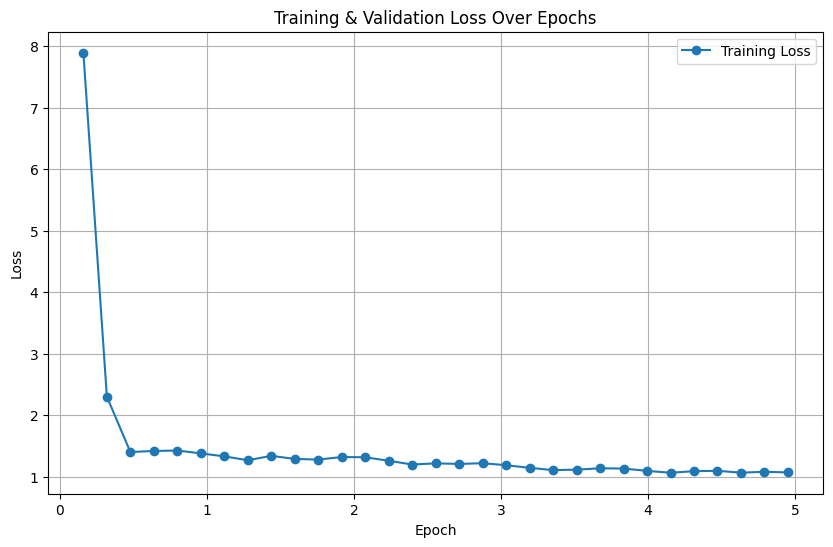

In [23]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_loss = []
eval_loss = []
epochs = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
        epochs.append(entry["epoch"])
    elif "eval_loss" in entry and "epoch" in entry:
        eval_loss.append(entry["eval_loss"])

# رسم المنحنى
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker='o')
if eval_loss:
    plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", marker='x')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import accuracy_score


def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}




In [27]:
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json',
 'my_model/tokenizer.json')

In [28]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

model = AutoModelForQuestionAnswering.from_pretrained("my_model")
tokenizer = AutoTokenizer.from_pretrained("my_model")

In [29]:
import gradio as gr
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer



qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

def get_answer(context, question):
    result = qa_pipeline(question=question, context=context)
    return result["answer"]


default_context = """الفِيلُ هو حيوان ثديي ضخم من فصيلة الفيليات ورتبة الخُرْطُومِيَّات،
مدة الحمل لدى الفيل هي 645 يومًا، ويوجد نوعان من الأفيال: الفيل الأفريقي والفيل الآسيوي،
تنتشر الفيلة في إفريقيا جنوب الصحراء الكبرى وجنوب شرق آسيا."""


gr.Interface(
    fn=get_answer,
    inputs=[
        gr.Textbox(label="📝 السياق", lines=6, value=default_context),
        gr.Textbox(label="❓ السؤال")
    ],
    outputs=gr.Textbox(label="✅ الإجابة"),
    title="نموذج سؤال وجواب باللغة العربية",
    description="ادخل سياقًا وسؤالًا بالعربية، وسيقوم النموذج بإرجاع الإجابة."
).launch()


Device set to use cuda:0


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f00deaf31bc1caba4f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [30]:
from collections import Counter
import string

def normalize_answer(s):
    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in string.punctuation)
    def lower(text):
        return text.lower()
    def white_space_fix(text):
        return ' '.join(text.split())
    return white_space_fix(remove_punc(lower(s)))

def compute_exact(a_pred, a_true):
    return int(normalize_answer(a_pred) == normalize_answer(a_true))

def compute_f1(a_pred, a_true):
    pred_tokens = normalize_answer(a_pred).split()
    true_tokens = normalize_answer(a_true).split()
    common = Counter(pred_tokens) & Counter(true_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0.0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

def evaluate_predictions(predictions, references):
    exact_scores = [compute_exact(p, t) for p, t in zip(predictions, references)]
    f1_scores = [compute_f1(p, t) for p, t in zip(predictions, references)]

    return {
        "Exact Match": sum(exact_scores) / len(exact_scores) * 100,
        "F1 Score": sum(f1_scores) / len(f1_scores) * 100
    }


In [32]:
predictions = []
references = []

for example in val_ar.select(range(20)):
    context = example["context"]
    question = example["question"]
    # The true answer was stored in 'answer_text' during preprocessing
    true_answer = example["answer_text"]

    result = qa_pipeline(question=question, context=context)
    predicted_answer = result["answer"]

    predictions.append(predicted_answer)
    references.append(true_answer)

results = evaluate_predictions(predictions, references)
print(results)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{'Exact Match': 0.0, 'F1 Score': 0.7196336192892623}
